In [1]:
from sklearn import decomposition
from caa.model import ModelWrapper
from caa.utils import load_dataset
import matplotlib.pyplot as plt
import torch as t
from tqdm import tqdm

In [ ]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'
device = "cuda:0"
model = ModelWrapper(model_name, hf_token="")
model.setup_layer_activation_hooks()

dataset = load_dataset("refusal")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model device cuda:0


In [3]:
def process_activations(activations): return t.stack(
        [activation.to('cpu')[:, -1] for activation in activations], dim=1)

all_activations_pos = []
all_activations_neg = []


# TODO: we probably want to batch this as some of the datasets are large
for data in tqdm(dataset):
    input = model.tokenize_question(data['question'], data['answer_matching_behavior'][:2]).to("cuda:0")  # this is the positive prompt
    model(input)
    activations_pos = model.get_last_layer_activations()
    all_activations_pos.append(process_activations(activations_pos))
        
    
for data in tqdm(dataset):
    input = model.tokenize_question(data['question'], data['answer_not_matching_behavior'][:2]).to("cuda:0")  # negative prompt
    model(input)
    activations_neg = model.get_last_layer_activations()
    all_activations_neg.append(process_activations(activations_neg))


# stack all tensors and flatten batch and question dimensions
activations_pos_tensor = t.stack(all_activations_pos, dim=0).flatten(0, 1)
activations_neg_tensor = t.stack(all_activations_neg, dim=0).flatten(0, 1)

100%|██████████| 458/458 [00:56<00:00,  8.05it/s]


In [4]:
# collate the response tokens for each type of prompt (positive or negative) to help plotting later
response_letters_pos = [data['answer_matching_behavior'] for data in dataset]
response_letters_neg = [data['answer_not_matching_behavior'] for data in dataset]

In [5]:
layer_9_activ_pos = activations_pos_tensor[:, 9]
layer_9_activ_neg = activations_neg_tensor[:, 9]

all_activations_layer_9 = t.cat([layer_9_activ_pos, layer_9_activ_neg])

In [6]:
pca = decomposition.PCA(n_components=2)
pca_proj_layer_9 = pca.fit_transform(all_activations_layer_9.numpy())
#X_layer_9_pos_B = pca.fit_transform(layer_9_activ_pos_B.numpy())
print(pca_proj_layer_9.shape)


(916, 2)


In [7]:
# separate the pca projected samples by pos / neg
samples = activations_pos_tensor.shape[0]

pca_proj_layer_9_pos = pca_proj_layer_9[:samples, :]
pca_proj_layer_9_neg = pca_proj_layer_9[samples:, :]

In [8]:
layer_10_activ_pos = activations_pos_tensor[:, 10]
layer_10_activ_neg = activations_neg_tensor[:, 10]

all_activations_layer_10 = t.cat([layer_10_activ_pos, layer_10_activ_neg])

pca_proj_layer_10 = pca.fit_transform(all_activations_layer_10.numpy())

pca_proj_layer_10_pos = pca_proj_layer_10[:samples, :]
pca_proj_layer_10_neg = pca_proj_layer_10[samples:, :]

[]

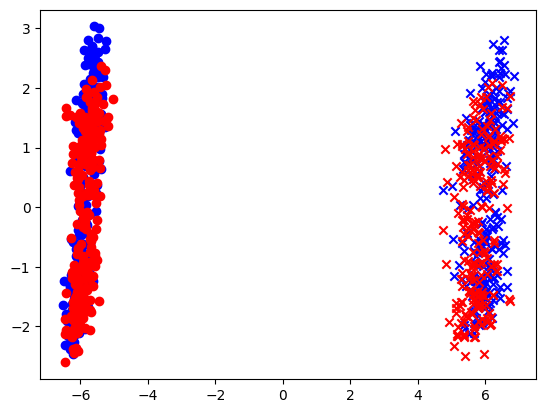

In [13]:
plt.clf()
for i, (pca1, pca2) in enumerate(pca_proj_layer_9_pos):
    if "A" in response_letters_pos[i]:  # pos - A
        plt.scatter(-pca1, -pca2, color="blue", marker="o")
    if "B" in response_letters_pos[i]:  # pos - B
        plt.scatter(-pca1, -pca2, color="blue", marker="x")

for i, (pca1, pca2) in enumerate(pca_proj_layer_9_neg):
    if "A" in response_letters_neg[i]:  # neg - A
        plt.scatter(-pca1, -pca2, color="red", marker="o")
    if "B" in response_letters_neg[i]:  # neg - B
        plt.scatter(-pca1, -pca2, color="red", marker="x")

plt.plot()

[]

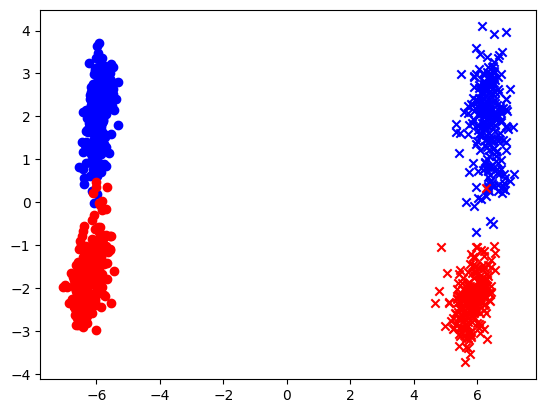

In [11]:
plt.clf()
for i, (pca1, pca2) in enumerate(pca_proj_layer_10_pos):
    if "A" in response_letters_pos[i]:  # pos - A
        plt.scatter(pca1, -pca2, color="blue", marker="o")
    if "B" in response_letters_pos[i]:  # pos - B
        plt.scatter(pca1, -pca2, color="blue", marker="x")

for i, (pca1, pca2) in enumerate(pca_proj_layer_10_neg):
    if "A" in response_letters_neg[i]:  # neg - A
        plt.scatter(pca1, -pca2, color="red", marker="o")
    if "B" in response_letters_neg[i]:  # neg - B
        plt.scatter(pca1, -pca2, color="red", marker="x")

plt.plot()